In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3213, done.
remote: Total 3213 (delta 0), reused 0 (delta 0), pack-reused 3213
Receiving objects: 100% (3213/3213), 582.57 MiB | 29.28 MiB/s, done.
Resolving deltas: 100% (1276/1276), done.
Checking out files: 100% (991/991), done.


In [ ]:
!mkdir -p /content/dataset/covid/
!mkdir -p /content/dataset/normal/
!mkdir -p /content/dataset/pneumonia/

In [ ]:
!unzip "/content/drive/My Drive/Datasets/Chest X-Ray Images (Pneumonia).zip"

In [ ]:
!mv /content/chest_xray/train/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/train/PNEUMONIA/* /content/dataset/pneumonia/
!mv /content/chest_xray/val/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/val/PNEUMONIA/* /content/dataset/pneumonia/
!mv /content/chest_xray/test/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/test/PNEUMONIA/* /content/dataset/pneumonia/

In [ ]:
import pandas as pd
import shutil
import os

# Selecting all combination of 'COVID-19' patients with 'PA' X-Ray view
virus = "COVID-19" # Virus to look for
x_ray_view = "PA" # View of X-Ray

meta_data = "/content/covid-chestxray-dataset/metadata.csv"
images_dir = "/content/covid-chestxray-dataset/images"
output_dir = "/content/dataset/covid/"

metadata_csv = pd.read_csv(meta_data)

for (i, row) in metadata_csv.iterrows():
	if row["finding"] != virus or row["view"] != x_ray_view:
		continue

	filename = row["filename"].split(os.path.sep)[-1]
	filePath = os.path.sep.join([images_dir, filename])
	shutil.copy2(filePath, output_dir)

  ## Pre-processing 

In [ ]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Input, average, Average, concatenate
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense

from keras.models import Sequential, Model
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications import DenseNet201
from keras.applications import MobileNet
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import os
import numpy as np
import pandas as pd
import time

import random

from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [ ]:
DATASET_DIR = "/content/dataset"

NORMAL_DIR = DATASET_DIR + "/normal"
PNEUMONIA_DIR = DATASET_DIR + "/pneumonia"
COVID_DIR = DATASET_DIR + "/covid"


IMG_W = 224
IMG_H = 224
IMG_C = 1
INPUT_SHAPE = (IMG_W, IMG_H, IMG_C)

CLASSES = [ "NORMAL", "PNEUMONIA", "COVID" ]
NB_CLASSES = len(CLASSES)

EPOCHS = 2
BATCH_SIZE = 16

In [ ]:
normal_images = []
pneumonia_images = []
covid_images = []

In [ ]:
for img_path in glob.glob(NORMAL_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    normal_images.append(img[:np.newaxis])

for img_path in glob.glob(PNEUMONIA_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    pneumonia_images.append(img[:np.newaxis])

for img_path in glob.glob(COVID_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    covid_images.append(img[:np.newaxis])

In [ ]:
len(normal_images), len(pneumonia_images), len(covid_images)

(1583, 4273, 201)

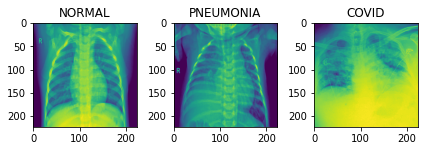

In [ ]:
width=150
height=150
rows = 1
cols = 3

imgs = [ normal_images[0], pneumonia_images[0], covid_images[0]]

axes=[]
fig=plt.figure()

for i in range(rows*cols):
    img = imgs[i]
    axes.append( fig.add_subplot(rows, cols, i+1) )
    plt.imshow(img)

axes[0].set_title('NORMAL')
axes[1].set_title('PNEUMONIA')
axes[2].set_title('COVID')
fig.tight_layout()    
plt.show()

In [ ]:
X = []
y = []

for item in normal_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    X.append(img)    
    y.append(CLASSES.index("NORMAL"))

for item in pneumonia_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    X.append(img)    
    y.append(CLASSES.index("PNEUMONIA"))

for item in covid_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    X.append(img)    
    y.append(CLASSES.index("COVID"))

X = np.asarray(X)
y = np.asarray(y)

In [ ]:
X.shape, y.shape

((6057, 224, 224, 1), (6057,))

In [ ]:
# from sklearn.model_selection import train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(
# #     X, y, test_size=0.2, random_state=2020)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=2020)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
X_val = X_test
y_val = y_test

In [ ]:
X_train = np.repeat(X_train[...,], 3, 3)
X_val = np.repeat(X_val[...,], 3, 3)
X_test = np.repeat(X_test[...,], 3, 3)

In [ ]:
X_train.shape, y_train.shape

((4845, 224, 224, 3), (4845,))

In [ ]:
X_test.shape, y_test.shape

((1212, 224, 224, 3), (1212,))

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([1274, 3411,  160]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([309, 862,  41]))

In [ ]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
train_da_args = dict(rescale=1./255, 
               shear_range=0.2,
               zoom_range=0.05,
               width_shift_range=0.05,
               height_shift_range=0.05,
               rotation_range=360,
               #  brightness_range=[0.2,1.0],
               vertical_flip=True,
               horizontal_flip=True)

# val_da_args = dict(rescale=1./255)

train_da = ImageDataGenerator(train_da_args)
# val_da = ImageDataGenerator(val_da_args)

train_da.fit(X_train, augment=True)
# val_da.fit(X_train)

train_gen = train_da.flow(X_train, y_train, batch_size=BATCH_SIZE)
# val_gen = train_da.flow(X_val, y_val)

In [ ]:
len(train_gen.x) 

4845

In [ ]:
# vgg_model = VGG16(weights='imagenet', 
#                         include_top=False, 
#                         input_shape=(IMG_H, IMG_W, 3))

# for layer in vgg_model.layers:
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False

# model = Sequential()
# model.add(vgg_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(NB_CLASSES, activation='softmax'))

In [ ]:
models_input = Input(shape=(IMG_H, IMG_W, 3))

resnet_model = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_tensor=models_input)

for layer in resnet_model.layers:
    layer.name = "resnet50_" + layer.name
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
        
resnet_gap = GlobalAveragePooling2D()(resnet_model.output)

vgg_model = VGG16(weights='imagenet', 
                        include_top=False, 
                        input_tensor=models_input)

for layer in vgg_model.layers:
    layer.name = "vgg16_" + layer.name
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

        
vgg_gap = GlobalAveragePooling2D()(vgg_model.output)

# Merging subnetworks
merged_nets = concatenate([resnet_gap, vgg_gap])

# x = Dense(NB_CLASSES)(merged_nets)
# out = Activation('softmax')(x)

inputs = input_tensor=models_input
outputs = merged_nets # out # average([resnet_model.output, vgg_model.output])
model = Model(inputs, outputs)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_resnet50_input_1 (InputLa (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50_conv1_pad (ZeroPadding (None, 230, 230, 3)  0           vgg16_resnet50_input_1[0][0]     
__________________________________________________________________________________________________
resnet50_conv1 (Conv2D)         (None, 112, 112, 64) 9472        resnet50_conv1_pad[0][0]         
__________________________________________________________________________________________________
resnet50_bn_conv1 (BatchNormali (None, 112, 112, 64) 256         resnet50_conv1[0][0]             
____________________________________________________________________________________________

In [ ]:
len(train_gen.x) // 60

80

In [ ]:
# # model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
# #           steps_per_epoch=  x_train.shape[0]//batch_size,
# #           epochs=epochs,
# #           verbose=1,
# #           class_weight=class_weight_dic)

# hist = model.fit_generator(train_gen,
#                     steps_per_epoch=len(train_gen.x)//BATCH_SIZE,
#                     epochs=EPOCHS,
#                     validation_data=(X_val, y_val),
#                     validation_steps=X_val.shape[0]//BATCH_SIZE)

In [ ]:
# hist = model.fit(X_train, 
#                  y_train, 
#                  batch_size=BATCH_SIZE, 
#                  epochs=3, 
#                  verbose=1, 
#                  callbacks=None, 
#                  validation_data=(X_val, y_val))

In [ ]:
features, labels = model.predict(X_train), y_train

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

y_labels = np.argmax(labels,axis = 1) 

folds = 3
param_comb = 5

start = time.time()

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, 
                    n_estimators=600, 
                    objective='multi:softmax', 
                    silent=True, 
                    nthread=1)

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 2020)

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                  #  scoring='roc_auc', 
                                   n_jobs=4, 
                                   cv=skf.split(features,y_labels), 
                                   verbose=3, 
                                   random_state=2020)

random_search.fit(features, y_labels)

end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 134.3min finished


Time taken in grid search:  8995.13


In [ ]:
best_score = random_search.best_score_
best_params = random_search.best_params_
print('Best Score using random search: \n', best_score)
print('Best Parameters using random search: \n', best_params)

Best Score using random search: 
 0.9552115583075335
Best Parameters using random search: 
 {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 1, 'colsample_bytree': 0.8}


In [ ]:
# # Set best parameters given by random search 
# xgb = XGBClassifier(learning_rate=0.02, 
#                     n_estimators=600, 
#                     objective='multi:softmax', 
#                     silent=True, 
#                     nthread=1)
xgb.set_params(subsample=0.6, 
               min_child_weight=5, 
               max_depth=4, 
               gamma=1, 
              #  max_features=None,
               colsample_bytree=0.8)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              max_features=None, min_child_weight=5, missing=None,
              n_estimators=600, n_jobs=1, nthread=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=0.6, verbosity=1)

In [ ]:
test_features, test_labels = model.predict(X_test), y_test

In [ ]:
xgb.fit(features, y_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              max_features=None, min_child_weight=5, missing=None,
              n_estimators=600, n_jobs=1, nthread=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=0.6, verbosity=1)

In [ ]:
predictions_xgb = xgb.predict(test_features)

In [ ]:
y_test_labels = np.argmax(test_labels, axis = 1) 
accuracy_xgb = xgb.score(test_features, y_test_labels)

In [ ]:
print("accuracy : ", accuracy_xgb)

accuracy :  0.9521452145214522


In [ ]:
# model.evaluate(X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
# Confusion matrix
# Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
    thresh = np.max(cm) // 2 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
# Y_pred = model.predict(X_test)
# Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Y_true = np.argmax(y_test,axis = 1) 
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

In [ ]:
# plot_confusion_matrix(confusion_mtx, classes = CLASSES)

In [ ]:
Y_pred = predictions_xgb
# Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_pred_classes = Y_pred
# Y_true = np.argmax(test_labels,axis = 1) 
Y_true = y_test_labels
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

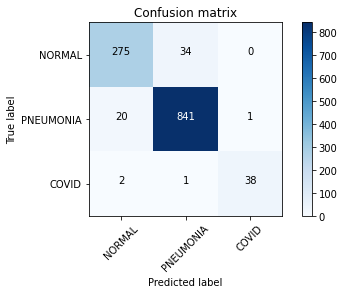

In [ ]:
plot_confusion_matrix(confusion_mtx, classes = CLASSES)

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # plot_confusion_matrix(confusion_mtx, classes = CLASSES, normalize=True)
# conf_mat = confusion_matrix(Y_true, Y_pred_classes)
# # Normalise
# conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(conf_mat_norm, annot=True, cmap=plt.cm.Blues, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show(block=False)


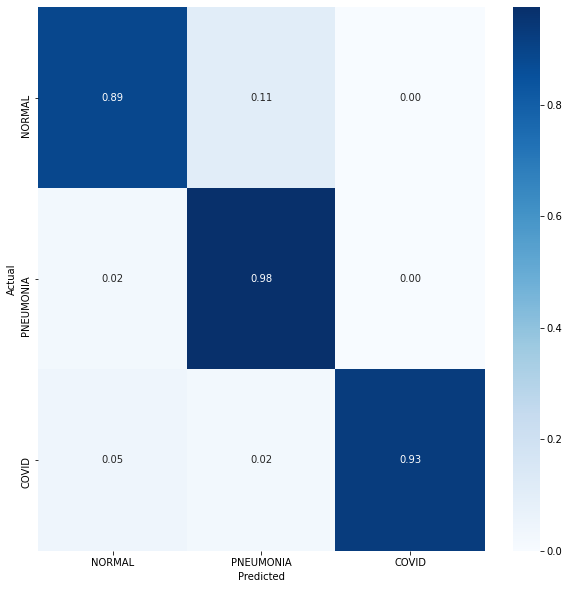

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# plot_confusion_matrix(confusion_mtx, classes = CLASSES, normalize=True)
conf_mat = confusion_matrix(Y_true, Y_pred_classes)
# Normalise
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat_norm, annot=True, cmap=plt.cm.Blues, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
model.save_weights('Covid19_Detection_pretrained_VGG_Resnet_XGB.h5')

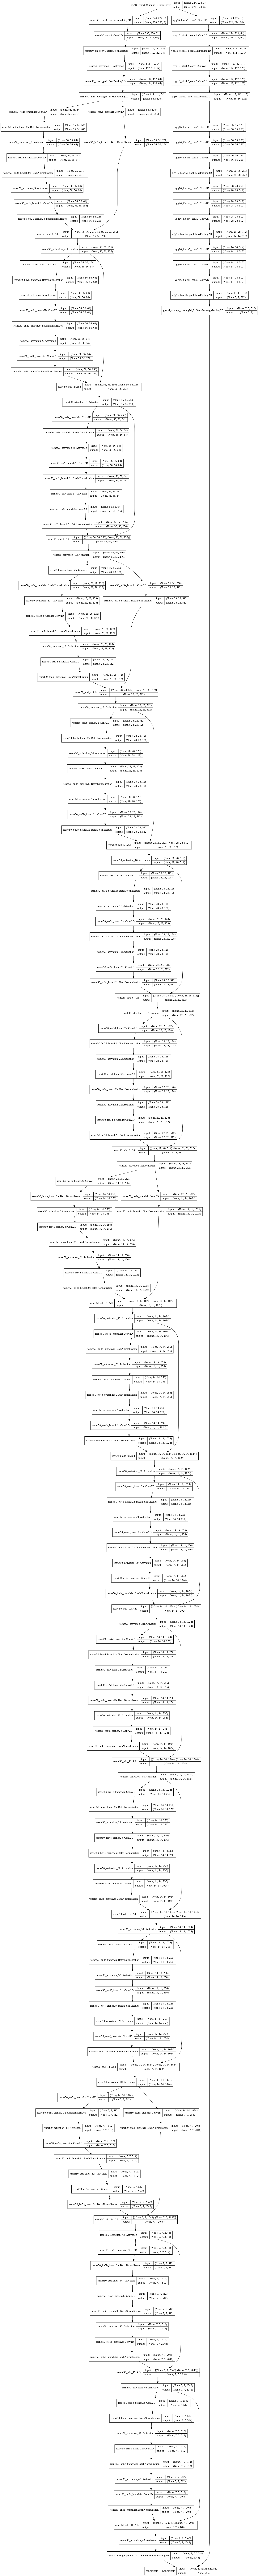

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='Covid19_Detection_pretrained_VGG_Resnet_XGB.png')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=2020)

In [ ]:
from sklearn.model_selection import GridSearchCV

np.random.seed(2020)
start = time.time()

param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(rf_clf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_rf.fit(features, labels)
print('Best Parameters using grid search: \n', cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

In [ ]:
# Set best parameters given by grid search 
rf_clf.set_params(bootstrap=True, criterion='entropy', max_depth=4, max_features=None)

In [ ]:
rf_clf.fit(features, labels)

In [ ]:
test_features, test_labels = model.predict(X_test), y_test

In [ ]:
predictions_rf = rf_clf.predict(test_features)

In [ ]:
accuracy_rf = rf_clf.score(test_features, test_labels)

In [ ]:
print("accuracy : ", accuracy_rf)